In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
from scipy.stats import norm

# **Max Cut**

## **Introduction**

The Max-Cut problem is a well-known NP-hard optimization problem. The goal is to partition the vertices of a graph into two sets such that the sum of the weights of the edges between the two sets is maximized. Mathematically, it can be formulated as:

$
\max_{x} \ x^T W x
$

$
\text{subject to} \ x \in \mathbb{R}^n, \ x_i^2 = 1 \ \forall i = 1, \ldots, n
$

where $W \in \mathbb{S}_+^n$ is a symmetric positive semidefinite matrix representing the weights of the graph.

## **Problem Formulation**

By defining $Y = xx^T$ , it can be prooved that the problem can be formulated to:


$\max_{Y} \ \text{trace}(WY) $

$\text{subject to}$

1) $\ Y \succeq 0$

2) $rank{(Y)} = 1$

3) $\ Y_{ii} = 1 \ \forall i$

While the 2nd constrain making the problem NP-hard and not convex.

## **Solution**
Given the complexity of the Max-Cut problem, we explore three different solution methods:

### **1. Semidefinite Programming (SDP) Relexation: We relax the problem using an SDP formulation:**

$\text{Defining } Y = xx^T$

$\max_{Y} \ \text{trace}(WY) $
$\text{subject to}$

1) $Y \succeq 0$

2) $diag{\{Y\}} = 1$

3) $Y_{ii} = 1 \ \forall i$

This relaxation makes the problem convex and solvable using standard optimization techniques. The SDP solution provides a bound for the original problem.

If we will mark the original problem as $P$ and the relexation of the problem as $R$, the the optimal solutions $p^*$ will satisfy $0.878\cdot p^*(R)<=p^*(P)$

We will perform the SDP solution using CVXPY.

CVXPY is an open source Python-embedded modeling language for convex optimization problems.

### **2. Randomized Algorithm (Stupid Algorithm):**

We will generate a random vector with entries drawn from a standard normal distribution and take the sign of each entry. This simple heuristic is computationally efficient but generally produces suboptimal results.

Mathematically, for each dimension $n$ we will choose randomly $x^* = sign(randn(n,1))$ and then we will calculate directly the value for $x^T W x$


### **3. Greedy Algorithm:**

We iteratively flip the sign of each component in the vector to maximize the objective value. This approach is straightforward and often yields better results than random guessing.
The Greedy algorithm formulation:

$\circ$ Initialize $x=0$

$\circ$ $\forall k=1,2,...n-1$:

- $y=x \text{ and } y_{k+1}=1$
- calculate $y^T W y$
- $z=x \text{ and } z_{k+1}=-1$
- calculate $z^T W z$
- if $z^T W z<= y^T W y$, then $x=y$, else $x=z$


## **Monte Carlo Simulation and Comparisons**

To compare the performance of these methods, we conduct Monte Carlo simulations for various dimensions $n = 2, 10, 50, 100$.

The steps are as follows:

1. **Generate Random Matrices:** For each dimension, generate 100 random symmetric positive semidefinite matrices $W$.
2. **Compute Solutions:** For each matrix, compute the solution using the three methods: SDP, randomized algorithm, and greedy algorithm.
3. **Analyze Results:**
   - Calculate the mean and standard deviation of the objective values obtained from each method.
   - Plot histograms to visualize the distribution of results.
   - Plot the mean objective values across different dimensions for each method.

By following these steps, we can evaluate the efficiency and accuracy of each method in solving the Max-Cut problem for different matrix sizes.

In [2]:
def generate_random_symmetric_psd_matrix(n):
    """
    Generate a random symmetric positive semidefinite matrix of dimension n x n.

    Parameters:
    n (int): Dimension of the matrix.

    Returns:
    np.ndarray: A symmetric positive semidefinite matrix.
    """
    A = np.random.uniform(-1, 1, (n, n))
    return np.dot(A, A.T)

def sdp_solver(W):
    """
    Solve the relaxed Max-Cut problem using Semidefinite Programming (SDP).

    Parameters:
    W (np.ndarray): Symmetric weights matrix.

    Returns:
    float: The objective value of the SDP solution.
    """
    n = W.shape[0]
    X = cp.Variable((n, n), symmetric=True)
    constraints = [X >> 0, cp.diag(X) == 1]
    objective = cp.Maximize(cp.trace(W @ X))
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return problem.value

def stupid_algorithm(W):
    """
    Solve the Max-Cut problem using a simple randomized algorithm.

    Parameters:
    W (np.ndarray): Symmetric weights matrix.

    Returns:
    float: The objective value of the randomized solution.
    """
    n = W.shape[0]
    x = np.sign(np.random.randn(n, 1))
    return np.dot(x.T, np.dot(W, x)).item()

def greedy_algorithm(W):
    """
    Solve the Max-Cut problem using a greedy algorithm.

    Parameters:
    W (np.ndarray): Symmetric weights matrix.

    Returns:
    float: The objective value of the greedy solution.
    """
    n = W.shape[0]
    x = np.zeros(n)
    for k in range(n):
        y = x.copy()
        y[k] = 1
        z = x.copy()
        z[k] = -1
        if np.dot(y.T, np.dot(W, y)) >= np.dot(z.T, np.dot(W, z)):
            x = y
        else:
            x = z
    return np.dot(x.T, np.dot(W, x))

def monte_carlo_simulation(n, num_simulations=100):
    """
    Perform Monte Carlo simulations to compare the solutions of the Max-Cut problem.

    Parameters:
    n (int): Dimension of the symmetric weights matrix.
    num_simulations (int): Number of Monte Carlo simulations.

    Returns:
    tuple: Three lists containing the results of SDP, stupid algorithm, and greedy algorithm.
    """
    sdp_results = []
    stupid_results = []
    greedy_results = []

    for _ in range(num_simulations):
        W = generate_random_symmetric_psd_matrix(n)
        sdp_results.append(sdp_solver(W))
        stupid_results.append(stupid_algorithm(W))
        greedy_results.append(greedy_algorithm(W))

    return sdp_results, stupid_results, greedy_results

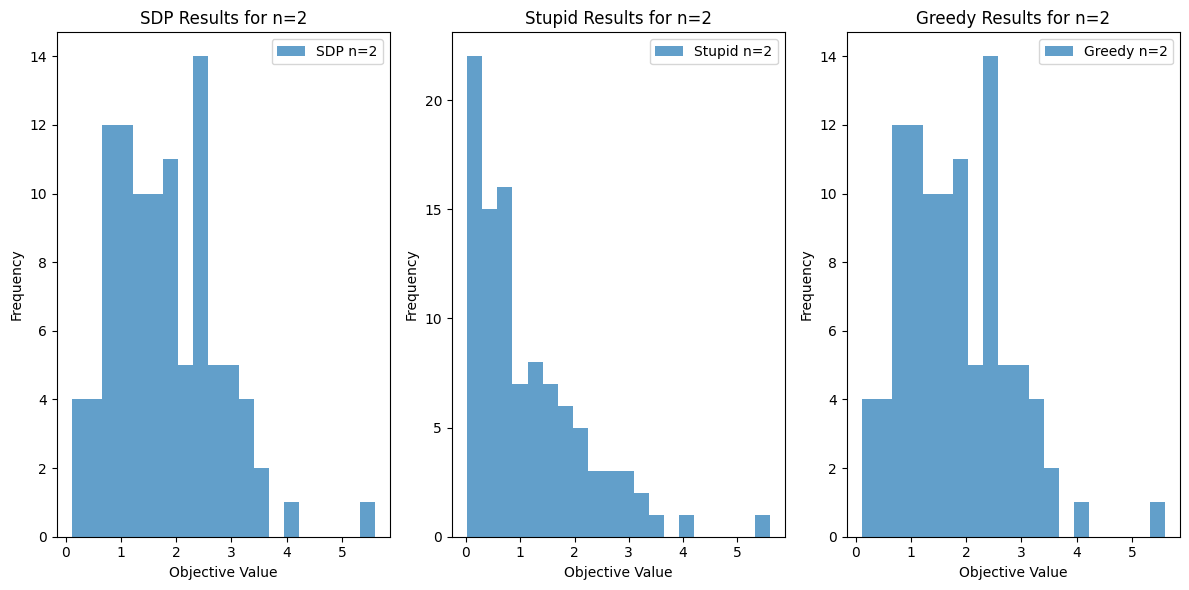

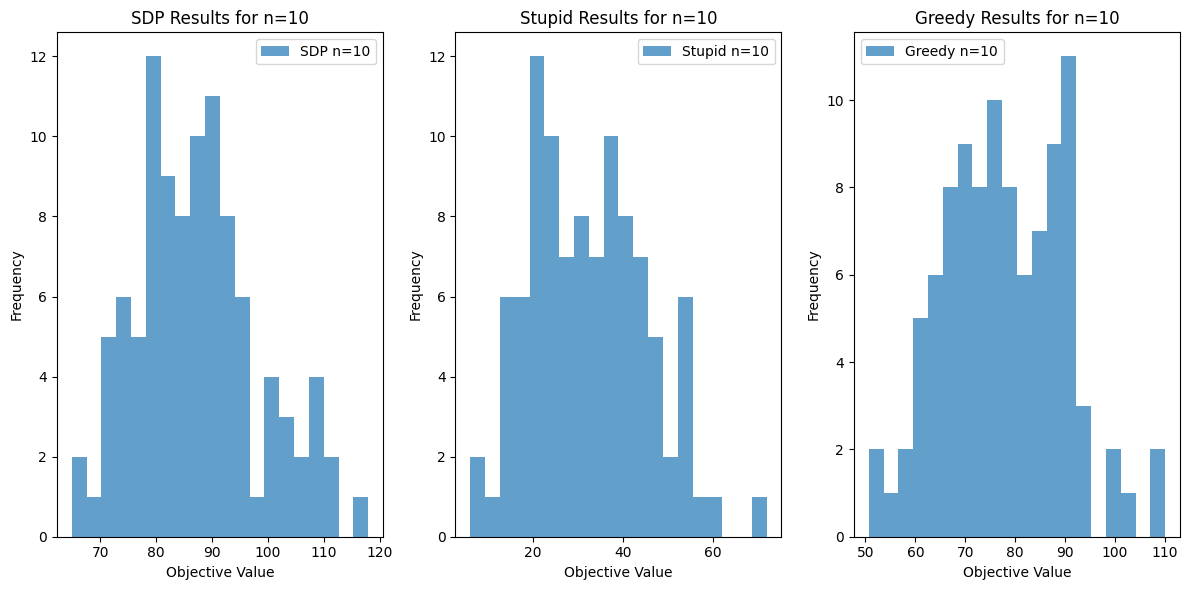

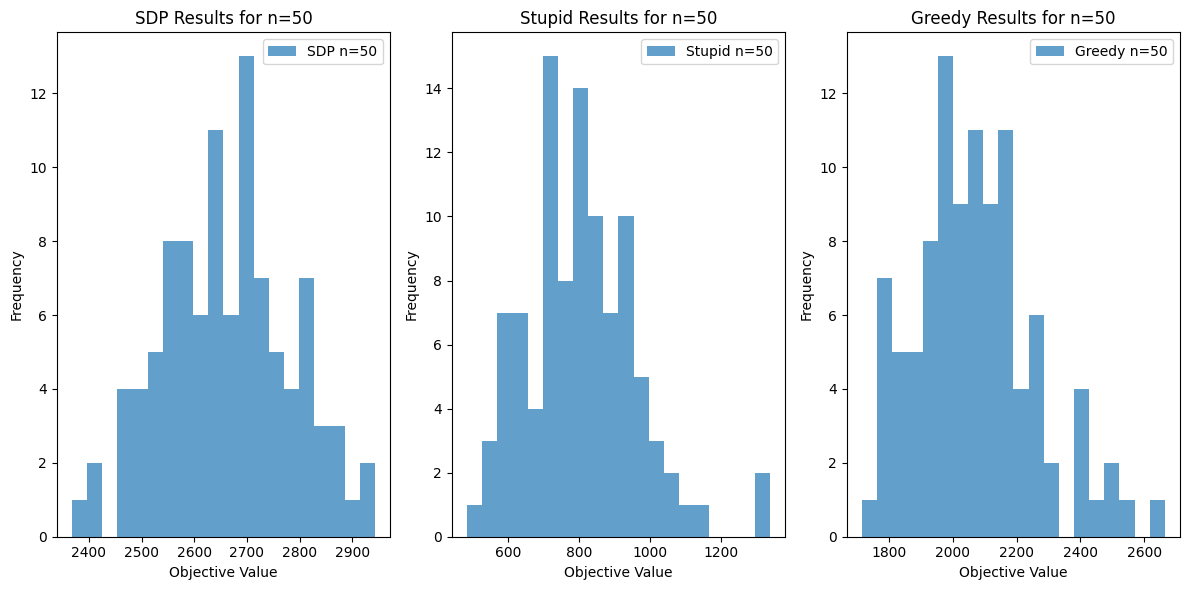

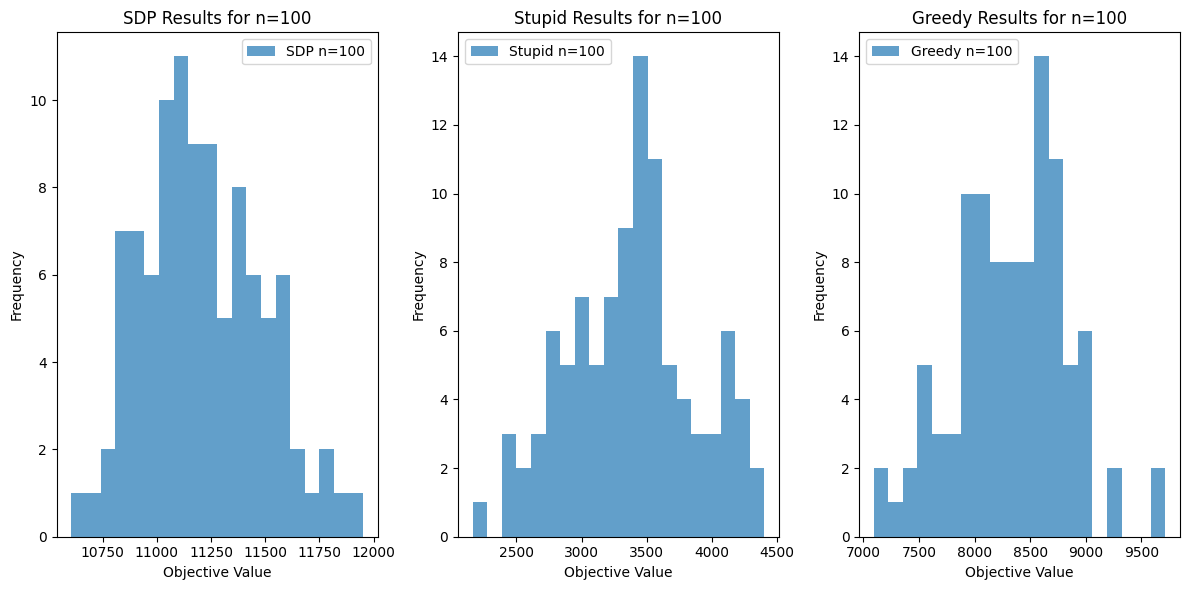

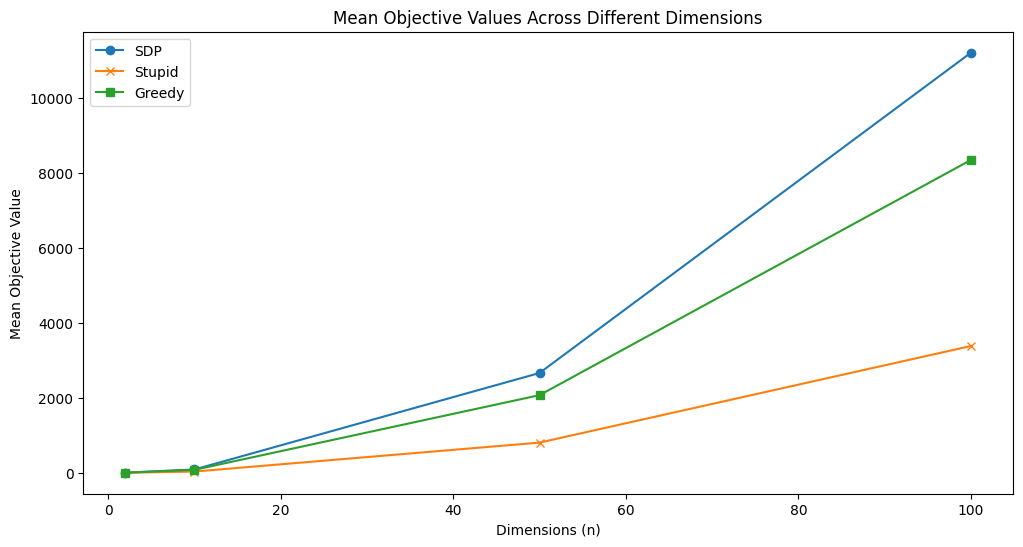

In [3]:
# Define the dimensions to test
dimensions = [2, 10, 50, 100]

# Initialize lists to store mean results for each dimension
sdp_means = []
stupid_means = []
greedy_means = []

# Perform Monte Carlo simulations for each dimension
for n in dimensions:
    sdp_results, stupid_results, greedy_results = monte_carlo_simulation(n)
    sdp_means.append(np.mean(sdp_results))
    stupid_means.append(np.mean(stupid_results))
    greedy_means.append(np.mean(greedy_results))

    # Plot histograms for the results of each method
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 3, 1)
    plt.hist(sdp_results, bins=20, alpha=0.7, label=f'SDP n={n}')
    plt.title(f'SDP Results for n={n}')
    plt.xlabel('Objective Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.hist(stupid_results, bins=20, alpha=0.7, label=f'Stupid n={n}')
    plt.title(f'Stupid Results for n={n}')
    plt.xlabel('Objective Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.hist(greedy_results, bins=20, alpha=0.7, label=f'Greedy n={n}')
    plt.title(f'Greedy Results for n={n}')
    plt.xlabel('Objective Value')
    plt.ylabel('Frequency')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot mean objective values across different dimensions
plt.figure(figsize=(12, 6))
plt.plot(dimensions, sdp_means, label='SDP', marker='o')
plt.plot(dimensions, stupid_means, label='Stupid', marker='x')
plt.plot(dimensions, greedy_means, label='Greedy', marker='s')
plt.xlabel('Dimensions (n)')
plt.ylabel('Mean Objective Value')
plt.legend()
plt.title('Mean Objective Values Across Different Dimensions')
plt.show()